In [1]:
import numpy as np
from scipy import fft
from scipy.sparse import csr_matrix
from scipy.io.wavfile import read
from librosa.core import note_to_hz
import matplotlib.pyplot as plt
from scipy.signal import get_window
import scipy
import filters

import torch
import torch.nn as nn
from torch.nn.functional import conv1d
from librosa import stft

In [2]:
# parameters
# nargin = 6
bins = 24 # bins per octave
fs = 22050 # sampling rate

# fmax = 61.73541266 # same as 1 octave
fmax = 880*4
fmin = note_to_hz('C1')
thresh= 0.0054

stride = 512

In [3]:
s = np.linspace(0,10,fs*10)
x = np.sin(2*np.pi*200*s, dtype=np.float32) + np.sin(2*np.pi*500*s, dtype=np.float32) +np.sin(2*np.pi*1000*s, dtype=np.float32) 

In [4]:
def nextpow2(A):
    return int(np.ceil(np.log2(A)))

In [5]:
def create_cqt_kernals(fmin, fmax, bins, fs, window):
    Q = 1/(2**(1/bins)-1)
    K = np.ceil(bins * np.log2(fmax / fmin)) # Calculate the number of bins
    fftLen = 2**nextpow2(np.ceil(Q * fs / fmin))
    minWin = 2**nextpow2(np.ceil(Q * fs / fmax))
    tempKernel = np.zeros((int(K), int(fftLen)), dtype=np.complex64)
    specKernel = np.zeros((int(K), int(fftLen)), dtype=np.complex64)
    freqs = fmin * 2.0 ** (np.r_[0:K] / np.float(bins))
    for k in range(0, int(K)):
        freq = freqs[k]
        l = np.ceil(Q * fs / freq)
        if l%2==1: # pad more zeros on RHS
            start = int(np.ceil(fftLen / 2.0 - l / 2.0))-1
        else:
            start = int(np.ceil(fftLen / 2.0 - l / 2.0))
        tempKernel[k, start:start + int(l)] = get_window(window,int(l), fftbins=True)*np.exp(np.r_[-l//2:l//2]*1j*2*np.pi*freq/fs)/l
        # specKernel[k, :]=fft(conj(tempKernel[k, :]))
        specKernel[k, :] = fft(tempKernel[k])
        
    return specKernel[:,:fftLen//2+1], fftLen

In [6]:
cqt_filter, kernal_width = create_cqt_kernals(fmin, fmax, bins, fs, 'hann')
cqt_filter_real = torch.tensor(cqt_filter.real)
cqt_filter_imag = torch.tensor(cqt_filter.imag)

In [21]:
wsin, wcos = filters.create_fourier_kernals(kernal_width, windowing="no", freq_scale='no')

In [26]:
fourier_real = conv1d(x_gpu[None,None,:], wcos, stride=stride)
fourier_imag = conv1d(x_gpu[None,None,:], wsin, stride=stride) # Doing STFT by using conv1d

In [32]:
spec = np.sqrt(fourier_real.pow(2)+fourier_imag.pow(2))

In [75]:
fourier_real.shape

torch.Size([1, 16385, 367])

In [88]:
test = torch.cat((fourier_real, fourier_real))

In [76]:
cqt_filter_real.shape

torch.Size([162, 16385])

In [90]:
torch.matmul(cqt_filter_real, test).shape

torch.Size([2, 162, 367])

In [91]:
CQT_real = torch.matmul(cqt_filter_real, fourier_real) - torch.matmul(cqt_filter_imag, fourier_imag)
CQT_imag = torch.matmul(cqt_filter_real, fourier_imag) + torch.matmul(cqt_filter_imag, fourier_real)

In [104]:
CQT_GPU = torch.sqrt(CQT_real.pow(2)+CQT_imag.pow(2))

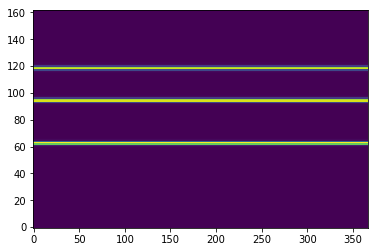

In [105]:
plt.imshow(CQT_GPU[0],aspect='auto', origin='lower')

# Calculating the spectrogram

In [98]:
x_fft = stft(x, kernal_width, hop_length=512, window='ones', center=False)

In [99]:
CQT = np.dot(cqt_filter, x_fft)

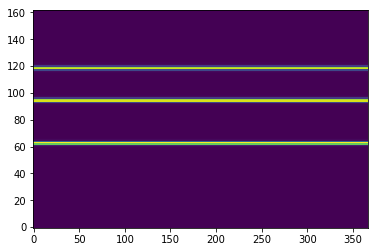

In [100]:
plt.imshow(abs(CQT),aspect='auto', origin='lower')

In [107]:
abs(CQT)

array([[8.9282187e-04, 6.6087570e-04, 4.8100465e-04, ..., 2.4923212e-03,
        2.0552385e-03, 1.6615066e-03],
       [6.6086015e-04, 3.7744609e-04, 1.7000080e-04, ..., 1.7984860e-02,
        1.7876044e-02, 1.7544553e-02],
       [6.3904776e-04, 7.9418527e-04, 9.1353065e-04, ..., 4.8832670e-02,
        4.8810653e-02, 4.8828620e-02],
       ...,
       [3.4701627e-01, 2.7944854e-01, 3.6189985e-01, ..., 2.0615542e+00,
        1.9949268e+00, 1.6311748e+00],
       [8.9624420e-02, 7.4002691e-02, 1.3924429e-01, ..., 2.5823603e+00,
        2.5544088e+00, 2.4117029e+00],
       [1.5928690e-01, 1.6232944e-01, 1.0717366e-01, ..., 6.7742133e-01,
        7.8580379e-01, 8.4052509e-01]], dtype=float32)

In [106]:
CQT_GPU

tensor([[[6.9934e-04, 6.2586e-04, 4.5983e-04,  ..., 2.4580e-03,
          2.1320e-03, 1.6594e-03],
         [5.1389e-04, 3.7514e-04, 1.2050e-04,  ..., 1.7935e-02,
          1.7859e-02, 1.7502e-02],
         [6.2056e-04, 8.0295e-04, 9.3981e-04,  ..., 4.8779e-02,
          4.8770e-02, 4.8793e-02],
         ...,
         [3.4704e-01, 2.7951e-01, 3.6180e-01,  ..., 2.0615e+00,
          1.9948e+00, 1.6312e+00],
         [8.5214e-02, 8.2105e-02, 1.1122e-01,  ..., 2.5577e+00,
          2.6046e+00, 2.4460e+00],
         [1.6572e-01, 1.4758e-01, 1.2546e-01,  ..., 5.9172e-01,
          7.2846e-01, 9.6423e-01]]])